In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

2번째에 있는 urllib는 웹에서 데이터를 다운로드 할 때 사용한다.
cv2는 OpenCV라이브러리로 이미지를 처리하기 위해 필요하다.
pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리이다.

(1440, 1152, 3)


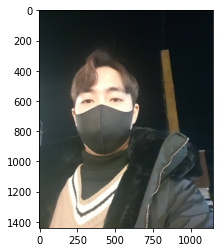

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

아이펠 이미지 폴더안에 준비되어있는 내 얼굴 사진을 업로드 해 보았다.

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f71d558e610>)

오늘 사진작업을 할 수 있게 프로그램을 다운로드 해온다.

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

오늘 다룰 시맨틱 세그멘테이션 모델을 생성해온다
시맨틱 세그멘테이션은 이미지에서 픽셀을 사람,자동차,비행기 등의 물리적단위로 분류하는 방법이라고 한다.

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

이제 시맨틱 모델에 이미지를 넣어보자

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

저기 위에 시맨틱 세그멘테이션 모델 불러올 때 2번째 줄에 pascalvoc란게 있었다.
이는 pascalvoc데이터로 학습된 모델을 이용하겠다는 의미이다.
이 pascalvoc데이터에는 21가지 데이터가 있고 나는 지금은 내 사진을 사용하니 
15번째에 있는 person(인물)을 사용해야겠다.

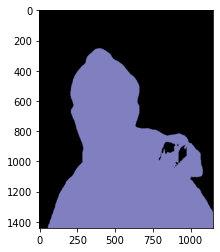

In [7]:
plt.imshow(output)
plt.show()

이미지를 출력해보면 내 사진은 파란색 배경은 검은색이 나와버렸다

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

바로 위에 pascalvoc에 인물사진이 15번째에 있었다.
내 이미지를 인공지능이 인물로 생각해서 15번째라고 판단한거 같다

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


여기서 저 위에 파스칼 목록에 있는것 중에
배경이랑 인물이라고 판단을 해준다.

In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

이거 출력값에 보면 맨 위에 0,0,0 되어 있는건 배경을 나타내는 거 같고
그 다음 16번째 줄에 192,128,128은 인물을 나타내는게 맞는거 같다.

In [11]:
colormap[15]

array([192, 128, 128])

인물의 색상을 확인해보면 방금 위에 16번째가 맞는거 같다.
근데 왜 15냐면 0부터 시작했기 때문

In [12]:
seg_color = (128,128,192)

근데 왜 순서를 역순으로 해주냐면
전에 이미지 불러왔을때 rgb가아니라 bgr이라서 파랑괴물이 됐었는데 이걸 다시 rgb로
바꿔줘야 하기 때문

(1440, 1152)


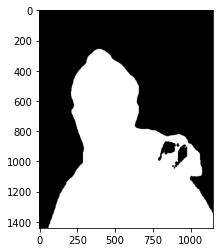

In [13]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

근데 위의 정보대로 이미지를 출력해보면
인물은 하얀색 배경은 까맣게 출력되었다.
분명히 색상 정보는 rgb 3채널이였을텐데 채널정보가 사라져버렸다.

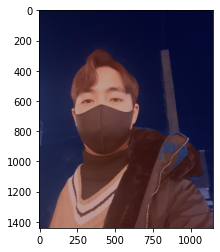

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.3, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이제 색상을 넣어주는데 인물사진은 붉으스름하게 배경은 퍼렇게 비율을 넣어서 출력해보면
이런 결과물이 나온다.

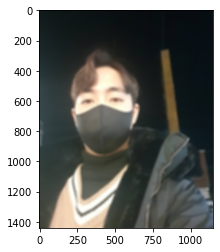

In [15]:
img_orig_blur = cv2.blur(img_orig, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

사진을 뿌옇게 해보자.
근데 원래 13,13하라고 하는데 나는 13으로 해도 별로 티가 안나서 20으로 고친 후 실행해 보았다.

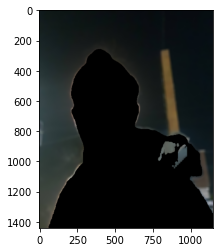

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

뿌옇게 만든 사진에서 세그멘테이션 마스크를 추출해보기 위해
원래 배경은 0, 인물상은 255였는데 bitwise를 이용한 연산을 하게 되면 배경이 255, 인물이 0이
되면서 인물의 픽셀이 모두 0이 되므로 내가 사라져버렸다.

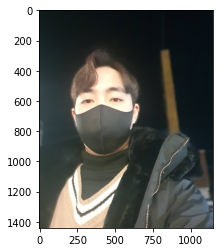

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

여기서 세그멘테이션 마스크가 255인 인물원본 이미지만 가져오고 나머지는 위에 뿌옇게 만든것처럼
뿌옇게 하면 나는 선명하고 배경은 뿌옇게 된 인물사진이 나온다.

(628, 620, 3)


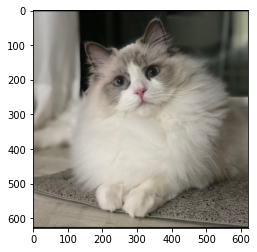

In [18]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

이번에는 고양이 사진을 가져와보자

In [19]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [20]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [21]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

이제 여기서 차이점이 나타나는데 아까 인물상은 15번이였지만 이제는 고양이라서 8번째에 있다.

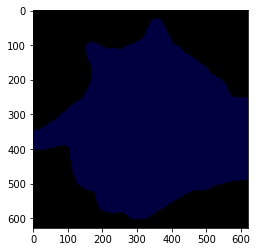

In [22]:
plt.imshow(output)
plt.show()

이것도 위에서처럼 고양이는 파란색 배경은 검은색이 나온다.

In [23]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

위에서 보여준 리스트에 8번째에 위치되어있다는것을 다시한번 확인할 수 있다.

In [24]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


배경과 고양이라고 정확하게 구분해냈다.

In [25]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

여기서 봐야할 부분은 8번째 64,0,0 부분이다.

In [26]:
colormap[8]

array([64,  0,  0])

여기서 고양이의 값을 확인시켜줬다.(bgr값)

In [27]:
seg_color = (0,0,64)

아까도 말했지만 bgr을 rgb로 바꿔주기 위해 역순을 해준다.

(628, 620)


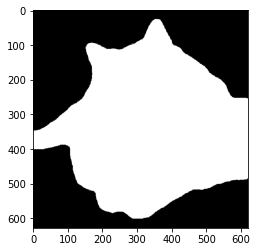

In [28]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

세그멘테이션 마스크를 분류해주기 위해 배경은 0 고양이는 1로 해주어서 흑백으로 나타내었다.

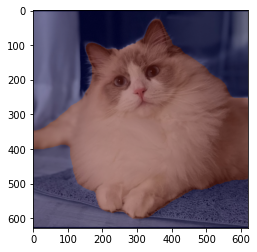

In [29]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.3, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

방금 흑백으로 나눠준 이미지에 다시 색상을 비율에 맞춰 입혀주면
고양이는 빨간색 배경은 파란색이다.

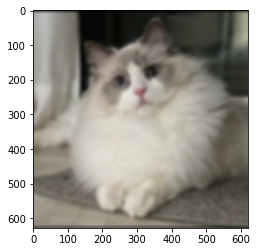

In [30]:
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

이건 아까 인물상과 다르게 13으로해도 뿌연게 티가 난다.

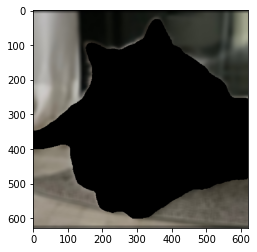

In [31]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

블러된 사진에 세그멘테이션 마스크를 추출하기 위해 bitwise로
배경 0과 고양이 255를 바꿔준다.

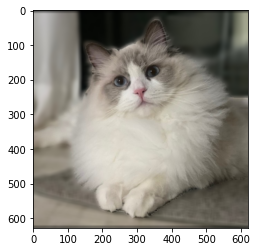

In [32]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

그리고 세그멘테이션으로 0값을 가지게 된 고양이에 다시 255를 넣어줘
컬러를 입히면 배경은 뿌옇고 고양이는 선명한 사진을 가지게 된다.

오늘 이 익스노드를 하면서 인물상을 어떻게 만들어내는지에 대해 알 수 있었다.
하지만 내 사진을 보면 왼쪽 부분 롱패딩 기모부분이 정확히 구분되지 못해서 배경이랑 똑같이 인식된거 같다.
저걸 고치려면 어떻게 해야될까...?
이 부분을 좀 더 생각해 봐야겠다.